In [19]:
import pandas as pd
import time
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

In [20]:
df_train = pd.read_csv("train.csv")

In [21]:
df_train.head(20)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
5,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
6,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
9,8c10229663,Через каждые сто градусов пятна краски меняют ...,Краска изменяется в соответствии с цветом.,ru,Russian,0


In [22]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
OUTPUT_PREFIX = './'
MODEL_CKPT = 'bert-base-multilingual-cased'
BATCH_SIZE = 2
EPOCHS = 20

In [23]:
input_ds = load_dataset('csv', data_files=TRAIN_PATH)

Found cached dataset csv (/home/blackswan/.cache/huggingface/datasets/csv/default-9b1258041fc1d378/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

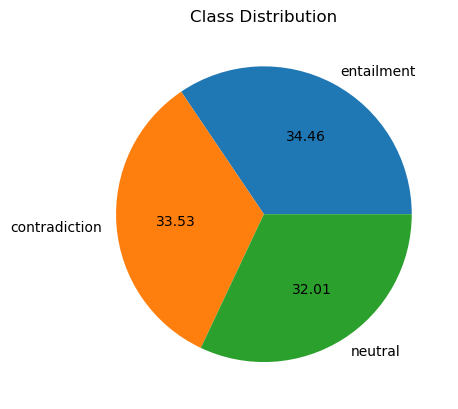

In [24]:
pd.Series(input_ds['train']['label']).map({0: 'entailment', 1:'neutral', 2:'contradiction'}).value_counts().plot.pie(title='Class Distribution', autopct='%.2f', ylabel='');

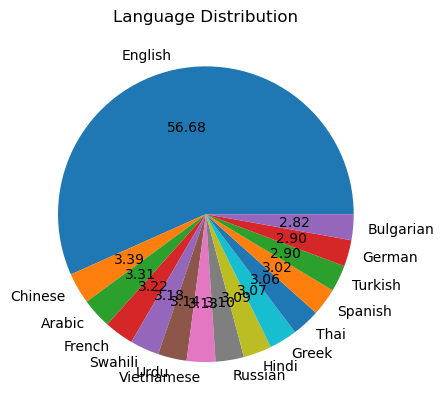

In [25]:
pd.Series(input_ds['train']['language']).value_counts().plot.pie(title='Language Distribution', autopct='%.2f', ylabel='');

In [26]:
clf_tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
print(f'>> Classifier Vocabulary Size: {clf_tokenizer.vocab_size}')
print(f'>> Classifier Model Max Length: {clf_tokenizer.model_max_length}')

def tokenize(examples):
    return clf_tokenizer(
        [p.replace('.', '').strip() + '.' + h.replace('.', ' ').strip() for p, h in zip(examples['premise'], examples['hypothesis'])],
        padding='max_length',
        truncation=True
    )
input_ds = input_ds.map(tokenize, batched=True).shuffle(seed=322)

input_ds = input_ds.remove_columns(['id', 'premise', 'hypothesis', 'language', 'lang_abv'])
input_ds = input_ds.rename_column('label', 'labels')

cutoff_idx = int(input_ds['train'].num_rows * 0.8)
train_ds = input_ds['train'].select(range(0, cutoff_idx))
eval_ds = input_ds['train'].select(range(cutoff_idx, input_ds['train'].num_rows))

train_ds.set_format('torch')
eval_ds.set_format('torch')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False)




Loading cached processed dataset at /home/blackswan/.cache/huggingface/datasets/csv/default-9b1258041fc1d378/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-f62a08cc377e9a7d.arrow
Loading cached shuffled indices for dataset at /home/blackswan/.cache/huggingface/datasets/csv/default-9b1258041fc1d378/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-532a39e859545c2c.arrow


>> Classifier Vocabulary Size: 119547
>> Classifier Model Max Length: 512


In [ ]:
def train_one_epoch(data_loader, model, optimizer):
    model.train(True)

    running_loss = 0
    last_loss = 0

    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        inputs =  batch
        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 499:
            last_loss = running_loss / 500
            print(f'>> Batch {i + 1} loss: {last_loss}')
            running_loss = 0
    return last_loss


def eval_one_epoch(data_loader, model):
    model.eval()

    total_correct = 0
    for i, vbatch in enumerate(data_loader):
        vinputs = vbatch
        with torch.no_grad():
            voutputs = model(**vinputs)
        logits = voutputs.logits
        preds = torch.argmax(logits, axis=-1)
        total_correct += (preds == vbatch['labels']).sum()
    accuracy = total_correct / data_loader.dataset.num_rows

    return accuracy.item()

 

clf_model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=3)
print(f'>> Classifier model footpring: {round(clf_model.get_memory_footprint() / (1024 * 1024), 2)} MB')

optimizer = AdamW(clf_model.parameters(), lr=5e-5)

for epoch in range(EPOCHS):
    print(f'\nEPOCH {epoch + 1}:')
    st = time.time(); avg_loss = train_one_epoch(train_loader, clf_model, optimizer); duration = time.time() - st
    print(f'>> Avg Loss: {avg_loss}, Duration: {duration}s')

    acc = eval_one_epoch(eval_loader, clf_model)
    print(f'>> Accuracy: {round(100 * acc, 2)}')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>> Classifier model footpring: 678.47 MB

EPOCH 1:
>> Batch 500 loss: 1.1302842199802399
>> Batch 1000 loss: 1.1232426210641862
>> Batch 1500 loss: 1.1153931424617767
>> Batch 2000 loss: 1.1112088516950607
>> Batch 2500 loss: 1.109754908800125
>> Batch 3000 loss: 1.1092587884664535
>> Batch 3500 loss: 1.1080187439918519
>> Batch 4000 loss: 1.1071059584617615
>> Batch 4500 loss: 1.106923886537552
>> Avg Loss: 1.106923886537552, Duration: 14761.266007184982s
>> Accuracy: 32.47

EPOCH 2:
>> Batch 500 loss: 1.105030594587326
>> Batch 1000 loss: 1.1051066348552703
>> Batch 1500 loss: 1.105087658405304
>> Batch 2000 loss: 1.1049908455610276
>> Batch 2500 loss: 1.106786058306694
>> Batch 3000 loss: 1.100580359339714
>> Batch 3500 loss: 1.107704291701317
>> Batch 4000 loss: 1.1034965866804123
>> Batch 4500 loss: 1.1046575350761414
>> Avg Loss: 1.1046575350761414, Duration: 14801.771443605423s
>> Accuracy: 33.46

EPOCH 3:
>> Batch 500 loss: 1.1030449099540711
>> Batch 1000 loss: 1.1047009586095